In [19]:
#from sklearn.model_selection import StratifiedKFold
#from sklearn.feature_selection import RFECV
#from multiprocess import Pool
import numpy as np
import pandas as pd
import os
from os.path import abspath, join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, auc, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
#import pickle

# Supervised learning

## Training

There are four training sets
each of which are divided into three feature sets - fs1, fs2, fs3

*fs1* - sequence, GC content, kmer weights, with or without fickett score

*fs2* - fs1 + pairing probabilities

*fs3* - fs2 + conservation scores

the pipeline is divided into three main parts:
1. dataset curation with the basic features
2. calculation of kmer weights and recording them in tuples (key, weight, frequency)
3. training the random forest classifier

*all datasets are downsampled to match the class with the least number of sequences by selecting random entries from every class.*

### Training on dataset 1

In [20]:
os.chdir("training_1")
#dataset 1 contains the payload along with 100 nt flanks
#there are 400 MIRHGs and 345 SNOHGs; to balance the dataset has been downsampled to 345 samples for each class

#each folder contains three directories fs[1,3] for the three feature sets
#which can be used to load the respective files to execute the training process

FileNotFoundError: [Errno 2] No such file or directory: 'training_1'

In [21]:
#the balanced dataset is loaded from each feature set-fickett score combination
flanks_down = pd.read_csv("fs1/w_fickett/down_fickett", index_col=0)
#for fs1
#w_fickett/down_fickett -> with fickett
#wo_fickett/down_no_fickett -> without fickett

#for fs2
#w_fickett/down_pp_fickett -> with fickett
#wo_fickett/down_pp_no_fickett -> without fickett

#for fs3
#w_fickett/down_cons_fickett -> with fickett
#wo_fickett/down_cons_no_fickett -> without fickett

In [22]:
flanks_down.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035 entries, 0 to 1034
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gene_id  1035 non-null   object 
 1   seq      1035 non-null   object 
 2   gc       1035 non-null   float64
 3   fickett  1035 non-null   float64
 4   target   1035 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.5+ KB


In [23]:
flanks_down.head()

,gene_id,seq,gc,fickett,target
0,ENSG00000232006.8.0,CAAATTCCTTATTTGATATTTAGTATTTGGAGTTAGGGGAAATGAG...,0.36,0.4954,sno
1,ENSG00000278610.1.0,TAAAATCTCACTTCCTATCCTATTCTTAAAAATGCATAGATTATAC...,0.35,0.3968,sno
2,SNHG15.0,TCTCTTCCAAGACACCTTCCCTTCTTCCTCAGCCAGAAAGGATCTT...,0.49,0.5531,sno
3,ENSG00000263307.1.0,TTATATGACATTCCAATTTCTGGGTCCGTAAGTAAAGTTTTACTGG...,0.47,0.6379,sno
4,ENSG00000255867.1.0,AACTAATCTGTGGGCTGGGCACAGTGGCTCACGCCTGTAATCCCAA...,0.46,0.6354,sno


kmer weights are calculated and saved in tuples for every kmer-sequence combination a tuple is created where

`key`: if the kmer is present in the sequence or not, [1,0]

`weight`: the normalized kmer weight

`frequency`: times the kmer occurs

In [24]:
#a multilabel binarizer is employed to create a feature from each of the tuple elements
cmlb=pd.read_hdf("fs1/cmlb5", key="mlb")

In [25]:
#the final training set is created combining all the features
features_combined = pd.concat([flanks_down, cmlb], axis=1, copy=False)

In [26]:
#we split the training set 80-20 for the classifier to train on

features_combined.drop(['gene_id'], 1, inplace=True)

#for phatscons/fs3
#val = {'cons_1':0, 'cons_2':0, 'cons_3':0, 'cons_4':0, 'cons_5':0, 'cons_6':0, 
#'cons_7':0, 'cons_8':0, 'cons_9':0, 'cons_10':0, 'cons_11':0, 'cons_12':0, 'cons_13':0, 
#'cons_14':0, 'cons_15':0, 'cons_16':0, 'cons_17':0, 'cons_18':0, 'cons_19':0, 'cons_20':0}
#features_combined_3.fillna(value=val, inplace=True)


ncrna_train, ncrna_test = train_test_split(features_combined, test_size=0.2, random_state=42)

ncrna_test_target=ncrna_test[["target"]]
ncrna_test=ncrna_test.drop(["target"],1)
print (ncrna_test_target.shape)
print (ncrna_test.shape)

ncrna_train_target=ncrna_train[["target"]]
ncrna_train=ncrna_train.drop(["target"],1)
print (ncrna_train_target.shape)
print (ncrna_train.shape)

#separating numerical features and categorical features
num_feat=[]
for x in ncrna_train.columns[1:]:
    num_feat.append(x)

cat_feat = ["seq"]

#encoding the sequence feature
#scaling the rest of the features
#and creating a ColumnTransformer object
cct = ColumnTransformer([
    ('oe', OrdinalEncoder(), cat_feat),
    ('num', StandardScaler(), num_feat)
    ], remainder='passthrough')

#fitting the split training set and test set
X_train = cct.fit_transform(ncrna_train)
X_test = cct.fit_transform(ncrna_test)

#encoding the target labels
ordinal = OrdinalEncoder()
y_train = ordinal.fit_transform(ncrna_train_target)
y_test = ordinal.fit_transform(ncrna_test_target)

y_train = np.ravel(y_train)

print (y_train.shape)
print (y_test.shape)

print (X_train.shape)
print (X_test.shape)

(207, 1)
(207, 7098)
(828, 1)
(828, 7098)
(828,)
(207, 1)
(828, 7098)
(207, 7098)


In [27]:
#training the random forest classifier with default params
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print (f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.8309178743961353


In [28]:
#grid search with 10-fold cv
param_grid = {'oob_score': [True, False], 'bootstrap':[True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def10 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
grid_search_def10.fit(X_train, y_train)

print (f"Grid search cv10 best score: {grid_search_def10.best_score_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.7min finished


Grid search cv10 best score: 0.8598883338230973


In [29]:
#grid search with 5-fold cv starts
param_grid = {'oob_score': [True, False], 'bootstrap': [True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def5 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
grid_search_def5.fit(X_train, y_train)

print (f"Grid search cv5 best score: {grid_search_def5.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.7min finished


Grid search cv5 best score: 0.8478495801387368


In [30]:
#model 1 is the best estimator from the grid search with 10-fold cv
#best parameters
best_params = grid_search_def10.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 500, 'oob_score': True}


In [31]:
#model 2 is the best estimator from the grid search with 5-fold cv
best_params = grid_search_def5.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 1000, 'oob_score': True}


In [32]:
#original model 
y_pred_orig = rnd_clf.predict(X_test)
print (accuracy_score(y_test, y_pred_orig))

0.8309178743961353


              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        63
         1.0       0.74      0.78      0.76        68
         2.0       0.81      0.74      0.77        76

    accuracy                           0.83       207
   macro avg       0.83      0.84      0.84       207
weighted avg       0.83      0.83      0.83       207



array([[63,  0,  0],
       [ 2, 53, 13],
       [ 1, 19, 56]])

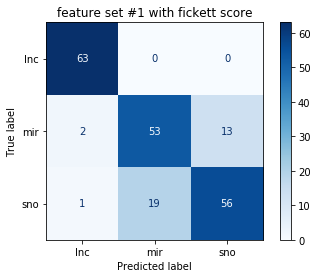

In [33]:
#classification matrix for the original model
print(classification_report(y_test, y_pred))

#path = "fs1/w_fickett/results"
#if not os.path.isdir(join(path)):
#    os.makedirs(join(path))
#plt.savefig(join(path,"feat_imp.png"))

disp = plot_confusion_matrix(rnd_clf, X_test, y_test,
                                     display_labels=["lnc","mir","sno"],
                                     cmap=plt.cm.Blues)
disp.ax_.set_title('feature set #1 with fickett score')
disp.confusion_matrix
#plt.savefig(join(path,"conf_mat.png"))

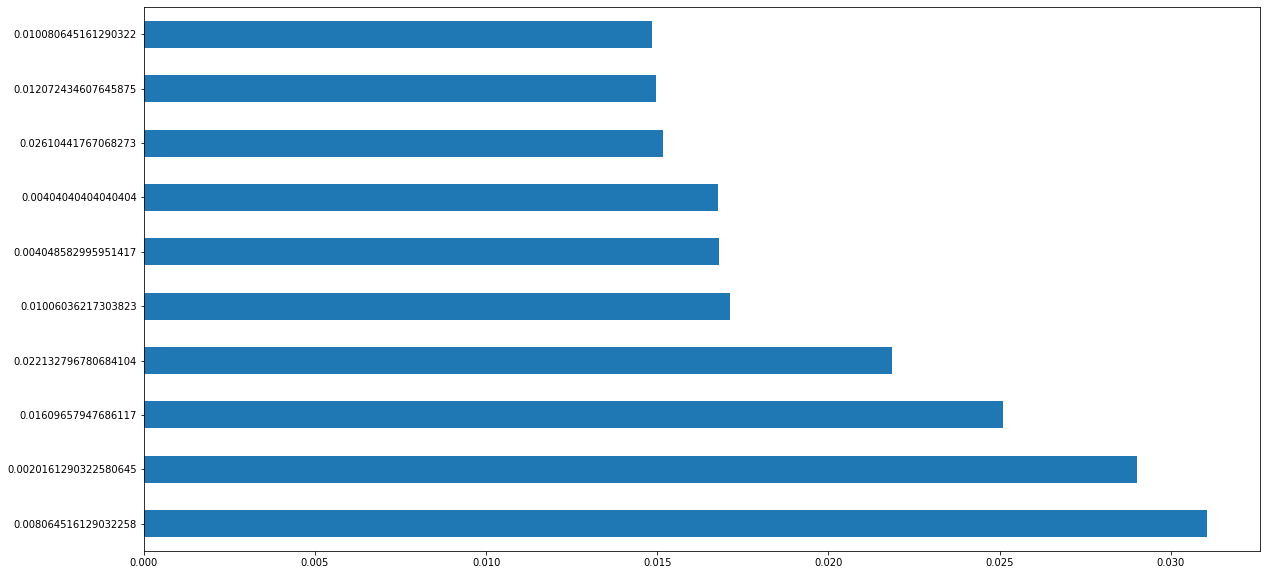

In [34]:
#feature importances
feat_imp = rnd_clf.feature_importances_
importances = pd.Series(feat_imp, index=features_combined.drop(["target"],1).columns)
importances.nlargest(10).plot(kind="barh",figsize=(20,10))

# Unsupervised learning
The next section follows the unsupervised learning setup.
k-means clustering of the three RNA classes and PCA with two components.

In [35]:
#k-means clustering of the three classes
y_test = np.ravel(y_test)

km = KMeans (n_clusters=3, init="k-means++", random_state=42).fit(X_train)

y = km.predict(X_test)

print (f'number of iterations : {km.n_iter_}\n')

#labels : {0: lnc, 1: mir, 2:sno}
#training set
print(f'predicted classes on the training set: {Counter(km.labels_)}\n')
print(f'actual classes on the trainig set: {Counter(y_train)}\n')
print(f'accuracy training set: {accuracy_score(y_train, km.labels_)}\n')
print(f'number of correctly classified samples: {accuracy_score(y_train, km.labels_, normalize=False)}\n')

#test set
print(f'predicted classes on the test set: {Counter(y)}\n')
print(f'actual classes on the test set: {Counter(y_test)}\n') 
print(f'accuracy test set: {accuracy_score(y_test, y)}')

number of iterations : 16

predicted classes on the training set: Counter({2: 278, 0: 278, 1: 272})

actual classes on the trainig set: Counter({0.0: 282, 1.0: 277, 2.0: 269})

accuracy training set: 0.3442028985507246

number of correctly classified samples: 285

predicted classes on the test set: Counter({2: 207})

actual classes on the test set: Counter({2.0: 76, 1.0: 68, 0.0: 63})

accuracy test set: 0.3671497584541063


explained variance ratio: [0.89200997 0.00130433]
n_compponents: 2
features: 7098
samples: 828


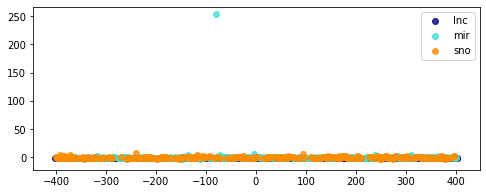

In [36]:
#pca
p = PCA(n_components=2, random_state=42)

X= p.fit_transform(X_train)

print(f'explained variance ratio: {p.explained_variance_ratio_}')
print(f'n_compponents: {p.n_components_}')
print(f'features: {p.n_features_}')
print(f'samples: {p.n_samples_}')

fig = plt.figure(figsize=(8,3))
colours = ['navy', 'turquoise', 'darkorange']
targets = ['lnc', 'mir', 'sno']
lw=2
for colour, i, target_name in zip(colours, [0, 1, 2], targets):
    plt.scatter(X[y_train == i, 0], X[y_train == i, 1], color=colour, alpha=.8, #lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

### End of training on dataset 1

### Dataset 2

In [37]:
os.chdir("../training_2")
#dataset 2 contains 100 nt flanks around the payload, but excluding the payload itself
#there are 800 MIRHGs and 690 SNOHGs; to balance the dataset has been downsampled to 690 samples for each class

#each folder contains three directories fs[1,3] for the three feature sets
#which can be used to load the respective files to execute the training process

In [38]:
#the balanced dataset is loaded from each feature set-fickett score combination
flanks_down = pd.read_csv("fs1/w_fickett/down_fickett", index_col=0)
#for fs1
#w_fickett/down_fickett -> with fickett
#wo_fickett/down_no_fickett -> without fickett

#for fs2
#w_fickett/down_pp_fickett -> with fickett
#wo_fickett/down_pp_no_fickett -> without fickett

#for fs3
#w_fickett/down_cons_fickett -> with fickett
#wo_fickett/down_cons_no_fickett -> without fickett

In [39]:
flanks_down.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2070 entries, 0 to 2069
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gene_id  2070 non-null   object 
 1   seq      2070 non-null   object 
 2   gc       2070 non-null   float64
 3   fickett  2070 non-null   float64
 4   target   2070 non-null   object 
dtypes: float64(2), object(3)
memory usage: 97.0+ KB


In [40]:
flanks_down.head()

,gene_id,seq,gc,fickett,target
0,ENSG00000236052.1.2,CTTCAGCAGTGCCCAGTGTTGCCAGGTGTGTGTTGTGTTGTGCTGT...,0.55,0.6362,sno
1,SNHG14.76,TGAGCCCTGTTCTCCCCTTGTGTCTTTCAGTGAGCTCTTCCACCAA...,0.57,0.8715,sno
2,ENSG00000249335.1.2,GAGAAATAGAAAGTGATGACATTAGTTGCCTCTGGGGAGAGGAACT...,0.38,0.7836,sno
3,ENSG00000250546.5.4,GAGGCCAAGGCAGGAGAACCACTTGAACCCAGGAGGTGGAGGTTGC...,0.60,0.5315,sno
4,SNHG14.69,TTACTTTTTTAGGAATAACACCCATGAGATACAGTTCTCATCTACT...,0.41,0.7502,sno


kmer weights are calculated and saved in tuples for every kmer-sequence combination a tuple is created where

`key`: if the kmer is present in the sequence or not, [1,0]

`weight`: the normalized kmer weight

`frequency`: times the kmer occurs

In [41]:
#a multilabel binarizer is employed to create a feature from each of the tuple elements
cmlb=pd.read_hdf("fs1/cmlb5", key="mlb")

In [42]:
#the final training set is created combining all the features
features_combined = pd.concat([flanks_down, cmlb], axis=1, copy=False)

In [43]:
#we split the training set 80-20 for the classifier to train on

features_combined.drop(['gene_id'], 1, inplace=True)

#for phatscons/fs3
#val = {'cons_1':0, 'cons_2':0, 'cons_3':0, 'cons_4':0, 'cons_5':0, 'cons_6':0, 
#'cons_7':0, 'cons_8':0, 'cons_9':0, 'cons_10':0, 'cons_11':0, 'cons_12':0, 'cons_13':0, 
#'cons_14':0, 'cons_15':0, 'cons_16':0, 'cons_17':0, 'cons_18':0, 'cons_19':0, 'cons_20':0}
#features_combined_3.fillna(value=val, inplace=True)


ncrna_train, ncrna_test = train_test_split(features_combined, test_size=0.2, random_state=42)

ncrna_test_target=ncrna_test[["target"]]
ncrna_test=ncrna_test.drop(["target"],1)
print (ncrna_test_target.shape)
print (ncrna_test.shape)

ncrna_train_target=ncrna_train[["target"]]
ncrna_train=ncrna_train.drop(["target"],1)
print (ncrna_train_target.shape)
print (ncrna_train.shape)

#separating numerical features and categorical features
num_feat=[]
for x in ncrna_train.columns[1:]:
    num_feat.append(x)

cat_feat = ["seq"]

#encoding the sequence feature
#scaling the rest of the features
#and creating a ColumnTransformer object
cct = ColumnTransformer([
    ('oe', OrdinalEncoder(), cat_feat),
    ('num', StandardScaler(), num_feat)
    ], remainder='passthrough')

#fitting the split training set and test set
X_train = cct.fit_transform(ncrna_train)
X_test = cct.fit_transform(ncrna_test)

#encoding the target labels
ordinal = OrdinalEncoder()
y_train = ordinal.fit_transform(ncrna_train_target)
y_test = ordinal.fit_transform(ncrna_test_target)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print (y_train.shape)
print (y_test.shape)

print (X_train.shape)
print (X_test.shape)

(414, 1)
(414, 222)
(1656, 1)
(1656, 222)
(1656,)
(414,)
(1656, 222)
(414, 222)


In [44]:
#training the random forest classifier with default params
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print (f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.3888888888888889


In [45]:
#grid search with 10-fold cv
param_grid = {'oob_score': [True, False], 'bootstrap':[True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def10 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
grid_search_def10.fit(X_train, y_train)

print (f"Grid search cv10 best score: {grid_search_def10.best_score_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.3min finished


Grid search cv10 best score: 0.40694779116465857


In [46]:
#grid search with 5-fold cv starts
param_grid = {'oob_score': [True, False], 'bootstrap': [True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def5 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
grid_search_def5.fit(X_train, y_train)

print (f"Grid search cv5 best score: {grid_search_def5.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   35.5s finished


Grid search cv5 best score: 0.40337604193207877


In [47]:
#model 1 is the best estimator from the grid search with 10-fold cv
#best parameters
best_params = grid_search_def10.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300, 'oob_score': True}


In [48]:
#model 2 is the best estimator from the grid search with 5-fold cv
best_params = grid_search_def5.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 500, 'oob_score': True}


In [49]:
#original model 
y_pred_orig = rnd_clf.predict(X_test)
print (accuracy_score(y_test, y_pred_orig))

0.3888888888888889


              precision    recall  f1-score   support

         0.0       0.35      0.32      0.33       142
         1.0       0.38      0.50      0.43       127
         2.0       0.45      0.37      0.40       145

    accuracy                           0.39       414
   macro avg       0.39      0.39      0.39       414
weighted avg       0.39      0.39      0.39       414



array([[45, 62, 35],
       [34, 63, 30],
       [50, 42, 53]])

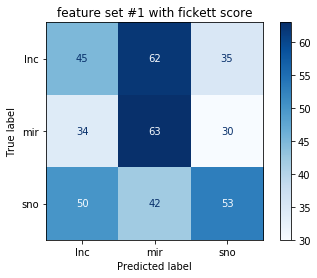

In [50]:
#classification matrix for the original model
print(classification_report(y_test, y_pred))

#path = "fs1/w_fickett/results"
#if not os.path.isdir(join(path)):
#    os.makedirs(join(path))
#plt.savefig(join(path,"feat_imp.png"))

disp = plot_confusion_matrix(rnd_clf, X_test, y_test,
                                     display_labels=["lnc","mir","sno"],
                                     cmap=plt.cm.Blues)
disp.ax_.set_title('feature set #1 with fickett score')
disp.confusion_matrix
#plt.savefig(join(path,"conf_mat.png"))

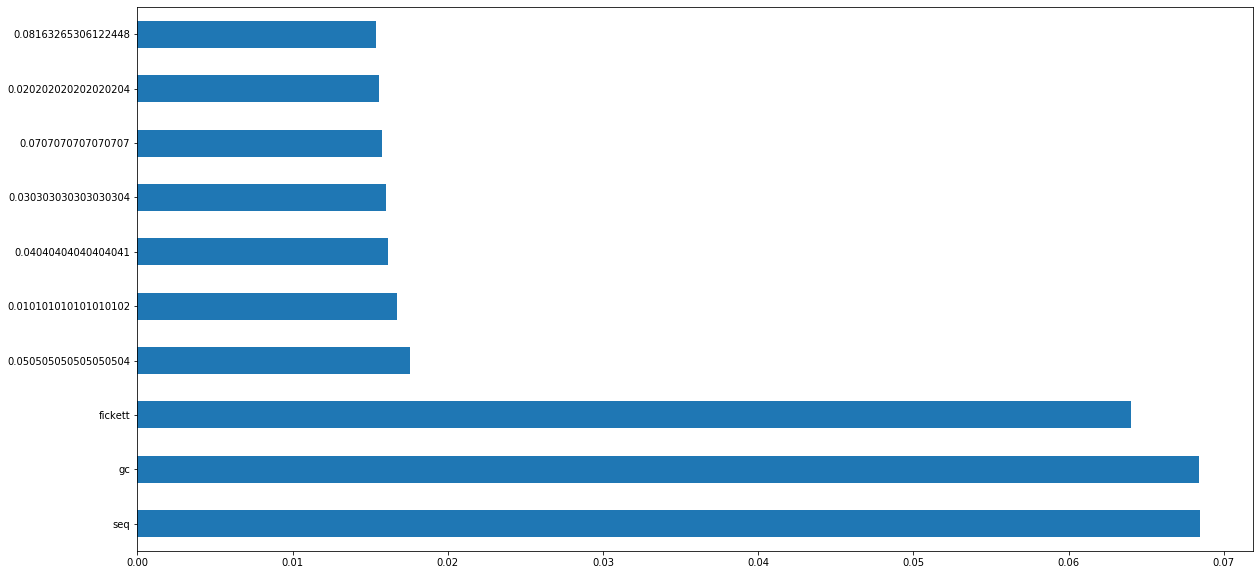

In [51]:
#feature importances
feat_imp = rnd_clf.feature_importances_
importances = pd.Series(feat_imp, index=features_combined.drop(["target"],1).columns)
importances.nlargest(10).plot(kind="barh",figsize=(20,10))

## Next follows the unsupervised learning on DS-2.

***k-means clustering of the three RNA classes and PCA with two components.***

In [52]:
#k-means clustering of the three classes
km = KMeans (n_clusters=3, init="k-means++", random_state=42).fit(X_train)

y = km.predict(X_test)

print (f'number of iterations : {km.n_iter_}\n')

#labels : {0: lnc, 1: mir, 2:sno}
#training set
print(f'predicted classes on the training set: {Counter(km.labels_)}\n')
print(f'actual classes on the trainig set: {Counter(y_train)}\n')
print(f'accuracy training set: {accuracy_score(y_train, km.labels_)}\n')
print(f'number of correctly classified samples: {accuracy_score(y_train, km.labels_, normalize=False)}\n')

#test set
print(f'predicted classes on the test set: {Counter(y)}\n')
print(f'actual classes on the test set: {Counter(y_test)}\n') 
print(f'accuracy test set: {accuracy_score(y_test, y)}')

number of iterations : 18

predicted classes on the training set: Counter({0: 555, 1: 554, 2: 547})

actual classes on the trainig set: Counter({1.0: 563, 0.0: 548, 2.0: 545})

accuracy training set: 0.3496376811594203

number of correctly classified samples: 579

predicted classes on the test set: Counter({0: 414})

actual classes on the test set: Counter({2.0: 145, 0.0: 142, 1.0: 127})

accuracy test set: 0.34299516908212563


explained variance ratio: [9.99050170e-01 4.03218651e-05]
n_compponents: 2
features: 222
samples: 1656


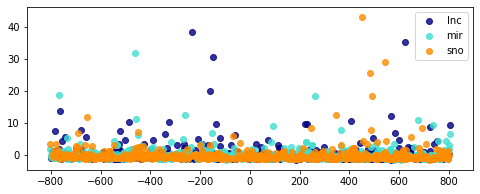

In [53]:
#pca
p = PCA(n_components=2, random_state=42)

X= p.fit_transform(X_train)

print(f'explained variance ratio: {p.explained_variance_ratio_}')
print(f'n_compponents: {p.n_components_}')
print(f'features: {p.n_features_}')
print(f'samples: {p.n_samples_}')

fig = plt.figure(figsize=(8,3))
colours = ['navy', 'turquoise', 'darkorange']
targets = ['lnc', 'mir', 'sno']
lw=2
for colour, i, target_name in zip(colours, [0, 1, 2], targets):
    plt.scatter(X[y_train == i, 0], X[y_train == i, 1], color=colour, alpha=.8, #lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

### End of training on DS-2

## Dataset 3 unsupervised

In [54]:
os.chdir("../training_3")
#dataset 3 contains 100 nt sequences from up and downstream exons
#there are 464 MIRHGs and 1287 SNOHGs; to balance the dataset has been downsampled to 464 samples for each class

#each folder contains three directories fs[1,3] for the three feature sets
#which can be used to load the respective files to execute the training process

In [55]:
#the balanced dataset is loaded from each feature set-fickett score combination
flanks_down = pd.read_csv("fs1/w_fickett/down_fickett", index_col=0)
#for fs1
#w_fickett/down_fickett -> with fickett
#wo_fickett/down_no_fickett -> without fickett

#for fs2
#w_fickett/down_pp_fickett -> with fickett
#wo_fickett/down_pp_no_fickett -> without fickett

#for fs3
#w_fickett/down_cons_fickett -> with fickett
#wo_fickett/down_cons_no_fickett -> without fickett

In [56]:
flanks_down.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1392 entries, 0 to 1391
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gene_id  1392 non-null   object 
 1   seq      1392 non-null   object 
 2   gc       1392 non-null   float64
 3   fickett  1392 non-null   float64
 4   target   1392 non-null   object 
dtypes: float64(2), object(3)
memory usage: 65.2+ KB


In [57]:
flanks_down.head()

,gene_id,seq,gc,fickett,target
0,ENSG00000225746.12.101,GTTTTCATGTTTATGAATTTTTATTTTACATTTATGATTGGCTCAA...,0.29,0.7132,sno
1,ENSG00000224078.15.360,CGGCCTTACTTTTTATTTTCAATTAAGTGAAACAATTACATGGAAA...,0.26,0.6176,sno
2,ENSG00000225746.12.0,CTGCTTTGTATTCCTCAGAATGAACAGCCCCATCTGATTTAATCAC...,0.45,0.7932,sno
3,ENSG00000224078.15.142,AAGTGAGATTTGTGTATGGTAAATATAATTAATTCAACCCCATGGA...,0.40,0.9823,sno
4,ENSG00000224078.15.646,AATCATGCTCAATAGGATTACGCTGAGGCCCAGTCTAGGTGAGAGT...,0.48,0.6644,sno


kmer weights are calculated and saved in tuples for every kmer-sequence combination a tuple is created where

`key`: if the kmer is present in the sequence or not, [1,0]

`weight`: the normalized kmer weight

`frequency`: times the kmer occurs

In [58]:
#a multilabel binarizer is employed to create a feature from each of the tuple elements
cmlb=pd.read_hdf("fs1/cmlb5", key="mlb")

In [59]:
#the final training set is created combining all the features
features_combined = pd.concat([flanks_down, cmlb], axis=1, copy=False)

In [60]:
#we split the training set 80-20 for the classifier to train on

features_combined.drop(['gene_id'], 1, inplace=True)

#for phatscons/fs3
#val = {'cons_1':0, 'cons_2':0, 'cons_3':0, 'cons_4':0, 'cons_5':0, 'cons_6':0, 
#'cons_7':0, 'cons_8':0, 'cons_9':0, 'cons_10':0, 'cons_11':0, 'cons_12':0, 'cons_13':0, 
#'cons_14':0, 'cons_15':0, 'cons_16':0, 'cons_17':0, 'cons_18':0, 'cons_19':0, 'cons_20':0}
#features_combined_3.fillna(value=val, inplace=True)


ncrna_train, ncrna_test = train_test_split(features_combined, test_size=0.2, random_state=42)

ncrna_test_target=ncrna_test[["target"]]
ncrna_test=ncrna_test.drop(["target"],1)
print (ncrna_test_target.shape)
print (ncrna_test.shape)

ncrna_train_target=ncrna_train[["target"]]
ncrna_train=ncrna_train.drop(["target"],1)
print (ncrna_train_target.shape)
print (ncrna_train.shape)

#separating numerical features and categorical features
num_feat=[]
for x in ncrna_train.columns[1:]:
    num_feat.append(x)

cat_feat = ["seq"]

#encoding the sequence feature
#scaling the rest of the features
#and creating a ColumnTransformer object
cct = ColumnTransformer([
    ('oe', OrdinalEncoder(), cat_feat),
    ('num', StandardScaler(), num_feat)
    ], remainder='passthrough')

#fitting the split training set and test set
X_train = cct.fit_transform(ncrna_train)
X_test = cct.fit_transform(ncrna_test)

#encoding the target labels
ordinal = OrdinalEncoder()
y_train = ordinal.fit_transform(ncrna_train_target)
y_test = ordinal.fit_transform(ncrna_test_target)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print (y_train.shape)
print (y_test.shape)

print (X_train.shape)
print (X_test.shape)

(279, 1)
(279, 222)
(1113, 1)
(1113, 222)
(1113,)
(279,)
(1113, 222)
(279, 222)


In [61]:
#training the random forest classifier with default params
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print (f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.6236559139784946


In [62]:
#grid search with 10-fold cv
param_grid = {'oob_score': [True, False], 'bootstrap':[True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def10 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
grid_search_def10.fit(X_train, y_train)

print (f"Grid search cv10 best score: {grid_search_def10.best_score_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   53.3s finished


Grid search cv10 best score: 0.6846846846846847


In [63]:
#grid search with 5-fold cv starts
param_grid = {'oob_score': [True, False], 'bootstrap': [True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def5 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
grid_search_def5.fit(X_train, y_train)

print (f"Grid search cv5 best score: {grid_search_def5.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.0s finished


Grid search cv5 best score: 0.6909546317618067


In [64]:
#model 1 is the best estimator from the grid search with 10-fold cv
#best parameters
best_params = grid_search_def10.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100, 'oob_score': True}


In [65]:
#model 2 is the best estimator from the grid search with 5-fold cv
best_params = grid_search_def5.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 500, 'oob_score': True}


In [66]:
#original model 
y_pred_orig = rnd_clf.predict(X_test)
print (accuracy_score(y_test, y_pred_orig))

0.6236559139784946


              precision    recall  f1-score   support

         0.0       0.63      1.00      0.78        93
         1.0       0.64      0.46      0.54        91
         2.0       0.59      0.41      0.48        95

    accuracy                           0.62       279
   macro avg       0.62      0.62      0.60       279
weighted avg       0.62      0.62      0.60       279



array([[93,  0,  0],
       [22, 42, 27],
       [32, 24, 39]])

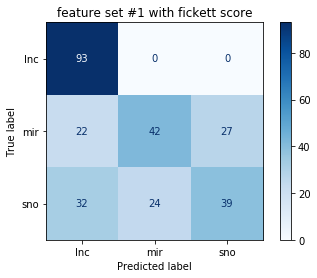

In [67]:
#classification matrix for the original model
print(classification_report(y_test, y_pred))

#path = "fs1/w_fickett/results"
#if not os.path.isdir(join(path)):
#    os.makedirs(join(path))
#plt.savefig(join(path,"feat_imp.png"))

disp = plot_confusion_matrix(rnd_clf, X_test, y_test,
                                     display_labels=["lnc","mir","sno"],
                                     cmap=plt.cm.Blues)
disp.ax_.set_title('feature set #1 with fickett score')
disp.confusion_matrix
#plt.savefig(join(path,"conf_mat.png"))

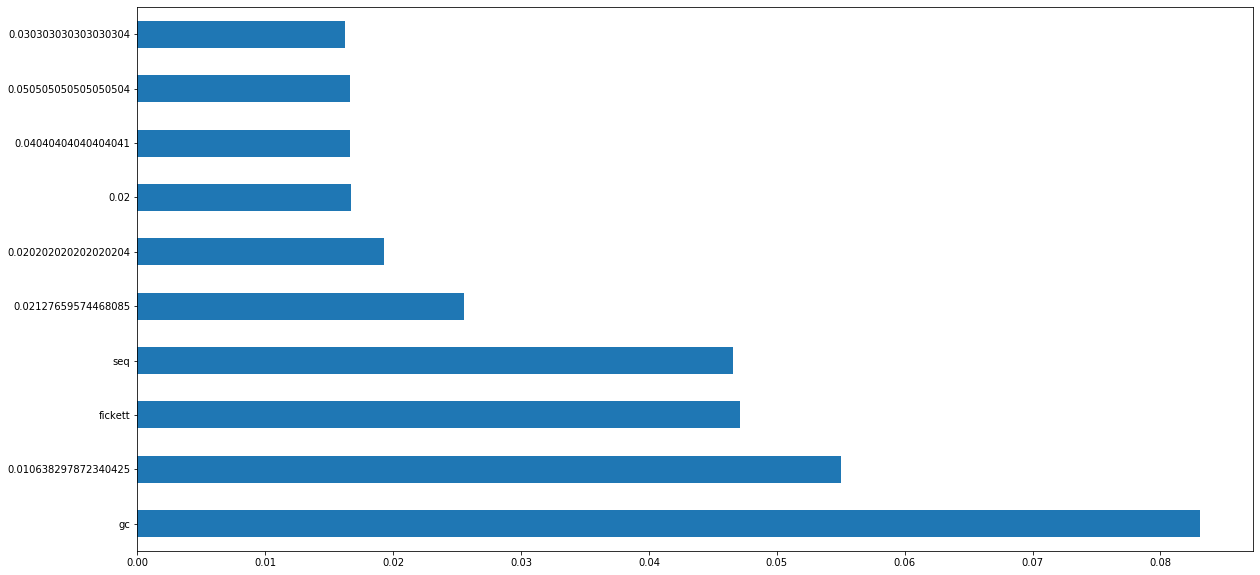

In [68]:
#feature importances
feat_imp = rnd_clf.feature_importances_
importances = pd.Series(feat_imp, index=features_combined.drop(["target"],1).columns)
importances.nlargest(10).plot(kind="barh",figsize=(20,10))

### Unsupervised learning DS-3

***k-means clustering of the three RNA classes and PCA with two components.***

In [69]:
#k-means clustering of the three classes
km = KMeans (n_clusters=3, init="k-means++", random_state=42).fit(X_train)

y = km.predict(X_test)

print (f'number of iterations : {km.n_iter_}\n')

#labels : {0: lnc, 1: mir, 2:sno}
#training set
print(f'predicted classes on the training set: {Counter(km.labels_)}\n')
print(f'actual classes on the trainig set: {Counter(y_train)}\n')
print(f'accuracy training set: {accuracy_score(y_train, km.labels_)}\n')
print(f'number of correctly classified samples: {accuracy_score(y_train, km.labels_, normalize=False)}\n')

#test set
print(f'predicted classes on the test set: {Counter(y)}\n')
print(f'actual classes on the test set: {Counter(y_test)}\n') 
print(f'accuracy test set: {accuracy_score(y_test, y)}')

number of iterations : 19

predicted classes on the training set: Counter({1: 372, 0: 371, 2: 370})

actual classes on the trainig set: Counter({1.0: 373, 0.0: 371, 2.0: 369})

accuracy training set: 0.35759209344115006

number of correctly classified samples: 398

predicted classes on the test set: Counter({2: 279})

actual classes on the test set: Counter({2.0: 95, 0.0: 93, 1.0: 91})

accuracy test set: 0.34050179211469533


explained variance ratio: [9.9807762e-01 1.4666543e-04]
n_compponents: 2
features: 222
samples: 1113


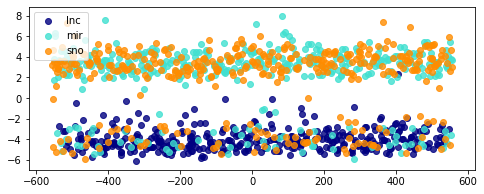

In [70]:
#pca
p = PCA(n_components=2, random_state=42)

X= p.fit_transform(X_train)

print(f'explained variance ratio: {p.explained_variance_ratio_}')
print(f'n_compponents: {p.n_components_}')
print(f'features: {p.n_features_}')
print(f'samples: {p.n_samples_}')

fig = plt.figure(figsize=(8,3))
colours = ['navy', 'turquoise', 'darkorange']
targets = ['lnc', 'mir', 'sno']
lw=2
for colour, i, target_name in zip(colours, [0, 1, 2], targets):
    plt.scatter(X[y_train == i, 0], X[y_train == i, 1], color=colour, alpha=.8, #lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

### End of training on DS-3

## Dataset 4 unsupervised

In [71]:
os.chdir("../training_4")
#dataset 4 contains 100 nt sequences from multiple, non-overlapping exons
#there are 168 MIRHGs and 162 SNOHGs; to balance the dataset has been downsampled to 162 samples for each class

#each folder contains three directories fs[1,3] for the three feature sets
#which can be used to load the respective files to execute the training process

In [72]:
#the balanced dataset is loaded from each feature set-fickett score combination
flanks_down = pd.read_csv("fs1/w_fickett/down_fickett", index_col=0)
#for fs1
#w_fickett/down_fickett -> with fickett
#wo_fickett/down_no_fickett -> without fickett

#for fs2
#w_fickett/down_pp_fickett -> with fickett
#wo_fickett/down_pp_no_fickett -> without fickett

#for fs3
#w_fickett/down_cons_fickett -> with fickett
#wo_fickett/down_cons_no_fickett -> without fickett

In [73]:
flanks_down.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 485
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gene_id  486 non-null    object 
 1   seq      486 non-null    object 
 2   gc       486 non-null    float64
 3   fickett  486 non-null    float64
 4   target   486 non-null    object 
dtypes: float64(2), object(3)
memory usage: 22.8+ KB


In [74]:
flanks_down.head()

,gene_id,seq,gc,fickett,target
0,ENSG00000285756.2.2,AACAGCGTATAAGCAAGCGTTCCCTTCTTTGCATTCTCGCCAAGAG...,0.45,0.8063,sno
1,ENSG00000227078.1.2,TATGTACATGAAATTACCTGATCGTTTATGGGGTCCAGATTTCCTT...,0.44,0.6074,sno
2,ENSG00000171889.5.3,AGAGTTTGGTTTTGTGTCCACAACACATTCTTTGTCCAATCAGCAT...,0.42,0.6621,sno
3,ENSG00000229267.3.3,GTGGGAAGATGTGCCTTGCTTTTCCTTCGCCTTCCTCCATGATCAT...,0.51,1.0266,sno
4,ENSG00000257683.1.0,GACTTCTCACCCATTTACTCTTGGCAAAAGGCAGCTTCCTGCTTCT...,0.44,0.6871,sno


kmer weights are calculated and saved in tuples for every kmer-sequence combination a tuple is created where

`key`: if the kmer is present in the sequence or not, [1,0]

`weight`: the normalized kmer weight

`frequency`: times the kmer occurs

In [75]:
#a multilabel binarizer is employed to create a feature from each of the tuple elements
cmlb=pd.read_hdf("fs1/cmlb5", key="mlb")

In [76]:
#the final training set is created combining all the features
features_combined = pd.concat([flanks_down, cmlb], axis=1, copy=False)

In [77]:
#we split the training set 80-20 for the classifier to train on

features_combined.drop(['gene_id'], 1, inplace=True)

#for phatscons/fs3
#val = {'cons_1':0, 'cons_2':0, 'cons_3':0, 'cons_4':0, 'cons_5':0, 'cons_6':0, 
#'cons_7':0, 'cons_8':0, 'cons_9':0, 'cons_10':0, 'cons_11':0, 'cons_12':0, 'cons_13':0, 
#'cons_14':0, 'cons_15':0, 'cons_16':0, 'cons_17':0, 'cons_18':0, 'cons_19':0, 'cons_20':0}
#features_combined_3.fillna(value=val, inplace=True)


ncrna_train, ncrna_test = train_test_split(features_combined, test_size=0.2, random_state=42)

ncrna_test_target=ncrna_test[["target"]]
ncrna_test=ncrna_test.drop(["target"],1)
print (ncrna_test_target.shape)
print (ncrna_test.shape)

ncrna_train_target=ncrna_train[["target"]]
ncrna_train=ncrna_train.drop(["target"],1)
print (ncrna_train_target.shape)
print (ncrna_train.shape)

#separating numerical features and categorical features
num_feat=[]
for x in ncrna_train.columns[1:]:
    num_feat.append(x)

cat_feat = ["seq"]

#encoding the sequence feature
#scaling the rest of the features
#and creating a ColumnTransformer object
cct = ColumnTransformer([
    ('oe', OrdinalEncoder(), cat_feat),
    ('num', StandardScaler(), num_feat)
    ], remainder='passthrough')

#fitting the split training set and test set
X_train = cct.fit_transform(ncrna_train)
X_test = cct.fit_transform(ncrna_test)

#encoding the target labels
ordinal = OrdinalEncoder()
y_train = ordinal.fit_transform(ncrna_train_target)
y_test = ordinal.fit_transform(ncrna_test_target)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print (y_train.shape)
print (y_test.shape)

print (X_train.shape)
print (X_test.shape)

(98, 1)
(98, 574)
(388, 1)
(388, 574)
(388,)
(98,)
(388, 574)
(98, 574)


In [78]:
#training the random forest classifier with default params
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print (f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.42857142857142855


In [79]:
#grid search with 10-fold cv
param_grid = {'oob_score': [True, False], 'bootstrap':[True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def10 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
grid_search_def10.fit(X_train, y_train)

print (f"Grid search cv10 best score: {grid_search_def10.best_score_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   46.3s finished


Grid search cv10 best score: 0.42004048582995945


In [80]:
#grid search with 5-fold cv starts
param_grid = {'oob_score': [True, False], 'bootstrap': [True],
              'criterion': ["gini", "entropy"], 'n_estimators':[100,300,500,1000]}
grid_search_def5 = GridSearchCV(RandomForestClassifier(random_state=42),
    param_grid, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
grid_search_def5.fit(X_train, y_train)

print (f"Grid search cv5 best score: {grid_search_def5.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   22.9s finished


Grid search cv5 best score: 0.43283383283383287


In [81]:
#model 1 is the best estimator from the grid search with 10-fold cv
#best parameters
best_params = grid_search_def10.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 1000, 'oob_score': True}


In [82]:
#model 2 is the best estimator from the grid search with 5-fold cv
best_params = grid_search_def5.best_params_
print (f"Grid search accuracy best params: {best_params}")

Grid search accuracy best params: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300, 'oob_score': True}


In [83]:
#original model 
y_pred_orig = rnd_clf.predict(X_test)
print (accuracy_score(y_test, y_pred_orig))

0.42857142857142855


              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51        37
         1.0       0.28      0.35      0.31        26
         2.0       0.48      0.40      0.44        35

    accuracy                           0.43        98
   macro avg       0.43      0.42      0.42        98
weighted avg       0.44      0.43      0.43        98



array([[19, 12,  6],
       [ 8,  9,  9],
       [10, 11, 14]])

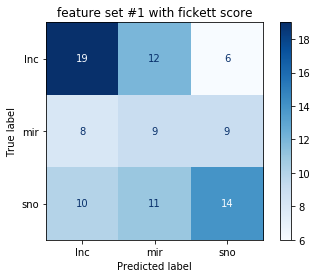

In [84]:
#classification matrix for the original model
print(classification_report(y_test, y_pred))

#path = "fs1/w_fickett/results"
#if not os.path.isdir(join(path)):
#    os.makedirs(join(path))
#plt.savefig(join(path,"feat_imp.png"))

disp = plot_confusion_matrix(rnd_clf, X_test, y_test,
                                     display_labels=["lnc","mir","sno"],
                                     cmap=plt.cm.Blues)
disp.ax_.set_title('feature set #1 with fickett score')
disp.confusion_matrix
#plt.savefig(join(path,"conf_mat.png"))

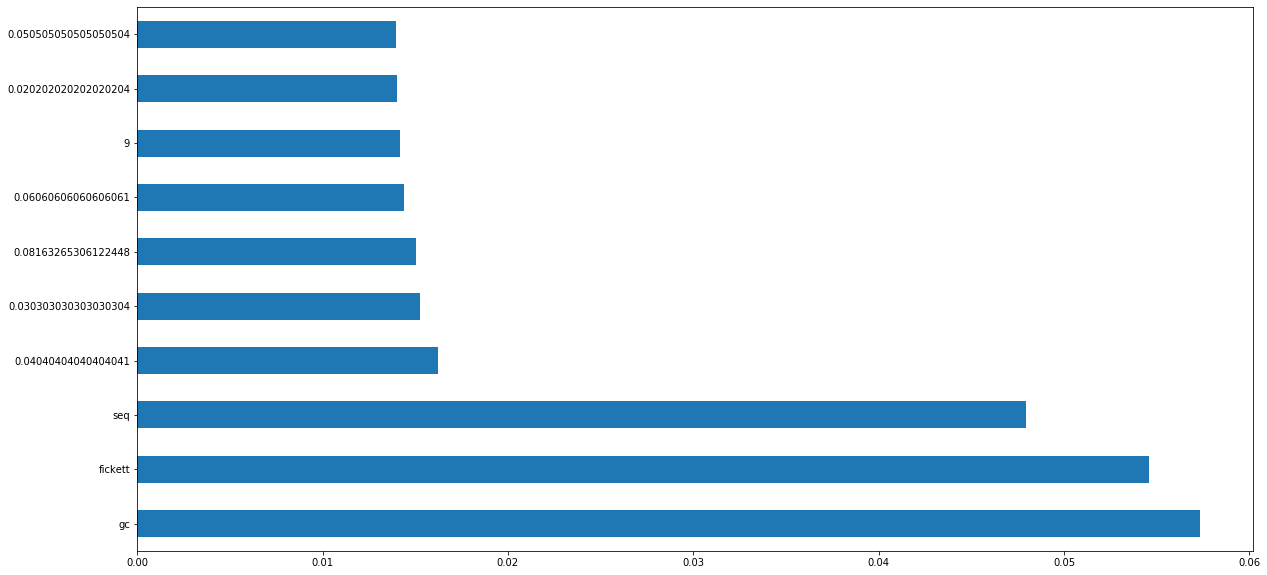

In [85]:
#feature importances
feat_imp = rnd_clf.feature_importances_
importances = pd.Series(feat_imp, index=features_combined.drop(["target"],1).columns)
importances.nlargest(10).plot(kind="barh",figsize=(20,10))

### Next the unsupervised learning for DS-4

***k-means clustering of the three RNA classes and PCA with two components.***

In [86]:
#k-means clustering of the three classes
km = KMeans (n_clusters=3, init="k-means++", random_state=42).fit(X_train)

y = km.predict(X_test)

print (f'number of iterations : {km.n_iter_}\n')

#labels : {0: lnc, 1: mir, 2:sno}
#training set
print(f'predicted classes on the training set: {Counter(km.labels_)}\n')
print(f'actual classes on the trainig set: {Counter(y_train)}\n')
print(f'accuracy training set: {accuracy_score(y_train, km.labels_)}\n')
print(f'number of correctly classified samples: {accuracy_score(y_train, km.labels_, normalize=False)}\n')

#test set
print(f'predicted classes on the test set: {Counter(y)}\n')
print(f'actual classes on the test set: {Counter(y_test)}\n') 
print(f'accuracy test set: {accuracy_score(y_test, y)}')

number of iterations : 5

predicted classes on the training set: Counter({0: 130, 2: 129, 1: 129})

actual classes on the trainig set: Counter({1.0: 136, 2.0: 127, 0.0: 125})

accuracy training set: 0.3479381443298969

number of correctly classified samples: 135

predicted classes on the test set: Counter({0: 98})

actual classes on the test set: Counter({0.0: 37, 2.0: 35, 1.0: 26})

accuracy test set: 0.37755102040816324


explained variance ratio: [0.95824547 0.00254755]
n_compponents: 2
features: 574
samples: 388


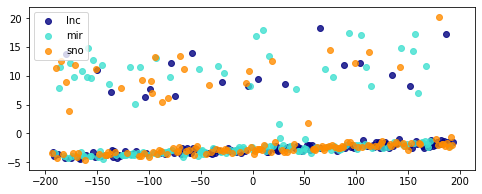

In [87]:
#pca
p = PCA(n_components=2, random_state=42)

X= p.fit_transform(X_train)

print(f'explained variance ratio: {p.explained_variance_ratio_}')
print(f'n_compponents: {p.n_components_}')
print(f'features: {p.n_features_}')
print(f'samples: {p.n_samples_}')

fig = plt.figure(figsize=(8,3))
colours = ['navy', 'turquoise', 'darkorange']
targets = ['lnc', 'mir', 'sno']
lw=2
for colour, i, target_name in zip(colours, [0, 1, 2], targets):
    plt.scatter(X[y_train == i, 0], X[y_train == i, 1], color=colour, alpha=.8, #lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

#### End of training on DS-4